In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import os
from torchvision.models import inception_v3
from scipy.linalg import sqrtm
from torchsummary import summary as Summary

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

latent_dim = 100
batch_size = 64
lr = 5e-5
img_shape = (3, 32, 32)
n_epochs = 50
n_critic = 5
c = 0.01

print(device)

cuda


In [3]:
# Load Inception-v3 in eval mode
inception = inception_v3(pretrained=True, transform_input=False)
inception.fc = torch.nn.Identity()  # Remove final classification layer
inception.aux_logits = False
inception.eval()

if torch.cuda.is_available():
    inception = inception.cuda()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 205MB/s] 


In [4]:
def preprocess_images(images):
    """Preprocess images for Inception-v3"""
    # Ensure images are in [0, 1] range
    if images.min() >= -1.0 and images.max() <= 1.0:
        # Input is in [-1, 1] range (GAN output)
        images = (images + 1.0) / 2.0
    elif images.max() > 1.0:
        # Input is in [0, 255] range
        images = images / 255.0
    else:
        # Already in [0, 1] range
        pass
    
    # Clamp to [0, 1]
    images = torch.clamp(images, 0.0, 1.0)
    
    # Resize to 299x299
    images = F.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)
    
    # ImageNet normalization
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
    
    if images.is_cuda:
        mean = mean.cuda()
        std = std.cuda()
    
    images = (images - mean) / std
    return images

In [5]:
def get_features(images, model):
    """Extract features using Inception-v3 (2048D from pool3 layer)"""
    model.eval()
    with torch.no_grad():
        if torch.cuda.is_available():
            images = images.cuda()
            
        # Preprocess images properly
        images = preprocess_images(images)
        
        # Use the standard forward pass to get pool3 features (2048D)
        # This automatically handles all the layers correctly
        features = model(images)  # This gives us the final pooled features
        
        # If features are still 2D (batch_size, features), we're good
        # If they're 4D, we need to pool them
        if len(features.shape) == 4:
            features = F.adaptive_avg_pool2d(features, (1, 1))
            features = torch.flatten(features, 1)
    
    return features.cpu()

In [6]:
def calculate_stats(features):
    """Calculate mean and covariance matrix"""
    features = features.numpy().astype(np.float64)  # Use float64 for numerical stability
    mu = np.mean(features, axis=0)
    sigma = np.cov(features, rowvar=False)
    return mu, sigma

In [7]:
def calculate_fid(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Calculate FID score"""
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)
    
    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)
    
    # Ensure matrices are symmetric (numerical stability)
    sigma1 = (sigma1 + sigma1.T) / 2
    sigma2 = (sigma2 + sigma2.T) / 2
    
    # Add small epsilon to diagonal for numerical stability
    sigma1 += eps * np.eye(sigma1.shape[0])
    sigma2 += eps * np.eye(sigma2.shape[0])
    
    diff = mu1 - mu2
    
    # Calculate sqrt of product of covariance matrices
    try:
        covmean, _ = sqrtm(sigma1.dot(sigma2), disp=False)
    except Exception as e:
        print(f"Error in sqrtm: {e}")
        # Fallback: add more regularization
        sigma1 += eps * 10 * np.eye(sigma1.shape[0])
        sigma2 += eps * 10 * np.eye(sigma2.shape[0])
        covmean, _ = sqrtm(sigma1.dot(sigma2), disp=False)
    
    # Handle numerical errors in sqrtm
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.absolute(covmean.imag))
            raise ValueError(f"Imaginary component {m}")
        covmean = covmean.real
    
    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

In [8]:
def compute_fid(real_images, fake_images, batch_size=64):
    """Compute FID between real and fake images"""
    # Create data loaders
    real_loader = DataLoader(real_images, batch_size=batch_size, shuffle=False)
    fake_loader = DataLoader(fake_images, batch_size=batch_size, shuffle=False)
    
    # Process real images
    real_features = []
    for batch in real_loader:
        real_features.append(get_features(batch, inception))
    real_features = torch.cat(real_features, dim=0)

    # Process fake images
    fake_features = []
    for batch in fake_loader:
        fake_features.append(get_features(batch, inception))
    fake_features = torch.cat(fake_features, dim=0)

    # Calculate statistics
    mu_real, sigma_real = calculate_stats(real_features)
    mu_fake, sigma_fake = calculate_stats(fake_features)

    return calculate_fid(mu_real, sigma_real, mu_fake, sigma_fake)

In [9]:
def evaluate_fid(generator, dataloader, sample_size, batch_size_fid, latent_dim, device):
    """Evaluate FID score for a generator"""
    generator.eval()
    
    # Generate fake images
    fake_images = []
    with torch.no_grad():
        for j in range(0, sample_size, batch_size_fid):
            current_batch = min(batch_size_fid, sample_size - j)
            z = torch.randn(current_batch, latent_dim).to(device)
            fake_batch = generator(z).cpu()
            fake_images.append(fake_batch)
    fake_images = torch.cat(fake_images, dim=0)

    # Collect real images
    real_images = []
    total_collected = 0
    for imgs, _ in dataloader:
        real_images.append(imgs)
        total_collected += imgs.size(0)
        if total_collected >= sample_size:
            break
    
    real_images = torch.cat(real_images, dim=0)[:sample_size]
    
    # Ensure we have the same number of real and fake images
    min_size = min(len(real_images), len(fake_images))
    real_images = real_images[:min_size]
    fake_images = fake_images[:min_size]
    
    # Compute FID
    fid = compute_fid(real_images, fake_images)
    
    generator.train()
    return fid

In [10]:
selected_classes = [2,3,4,5,6,7]

class CIFAR10Subset(Dataset):
    def __init__(self, root, train=True, selected_labels=None, transform=None):
        self.full_dataset = datasets.CIFAR10(root=root, train=train, transform=transform, download=True)
        self.selected_labels = selected_labels if selected_labels is not None else list(range(10))
        self.indices = [i for i, (_, label) in enumerate(self.full_dataset) if label in self.selected_labels]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        true_idx = self.indices[idx]
        img, label = self.full_dataset[true_idx]
        return img, label

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

subset = CIFAR10Subset(root='./data', train=True, selected_labels=selected_classes, transform=transform)
dataloader = DataLoader(subset, batch_size=64, shuffle=True)

100%|██████████| 170M/170M [00:04<00:00, 37.0MB/s] 


In [11]:
len(dataloader) * batch_size

30016

*All the things are already mentioned till now in notebook 1*

Here we first tried to interchanging the critic and generator combination between Architecture 2 and 3 and proceeded further based on the observations 

In [12]:
class Generator_2(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.model = nn.Sequential(
            # Input: latent_dim x 1 x 1
            nn.ConvTranspose2d(latent_dim, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # Output: 512 x 4 x 4
            
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # Output: 256 x 8 x 8
            
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # Output: 128 x 16 x 16
            
            nn.ConvTranspose2d(128, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
            # Output: 3 x 32 x 32
        )
    
    def forward(self, z):
        if z.ndim == 2:
            z = z.view(z.size(0), z.size(1), 1, 1)
        return self.model(z)

generator = Generator_2(latent_dim).to(device)
print(Summary(generator, (latent_dim,1,1)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10            [-1, 3, 32, 32]           6,144
             Tanh-11            [-1, 3, 32, 32]               0
Total params: 3,448,576
Trainable params: 3,448,576
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

In [25]:
class Generator_3(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128 * 8 * 8),
            nn.ReLU(),
            nn.Unflatten(1, (128, 8, 8)),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128, momentum=0.78),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64, momentum=0.78),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img

generator = Generator_3(latent_dim).to(device)
print(Summary(generator, input_size=(latent_dim,), batch_size=batch_size, device="cuda"))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [64, 8192]         827,392
              ReLU-2                 [64, 8192]               0
         Unflatten-3            [64, 128, 8, 8]               0
          Upsample-4          [64, 128, 16, 16]               0
            Conv2d-5          [64, 128, 16, 16]         147,584
       BatchNorm2d-6          [64, 128, 16, 16]             256
              ReLU-7          [64, 128, 16, 16]               0
          Upsample-8          [64, 128, 32, 32]               0
            Conv2d-9           [64, 64, 32, 32]          73,792
      BatchNorm2d-10           [64, 64, 32, 32]             128
             ReLU-11           [64, 64, 32, 32]               0
           Conv2d-12            [64, 3, 32, 32]           1,731
             Tanh-13            [64, 3, 32, 32]               0
Total params: 1,050,883
Trainable param

In [19]:
class Critic_2(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
            # Input: 3 x 32 x 32
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 64 x 16 x 16
            
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # 128 x 8 x 8
            
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # 256 x 4 x 4
            
            # Global average pooling instead of another conv layer
            nn.AdaptiveAvgPool2d(1),  # 256 x 1 x 1
            nn.Flatten(),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        return self.model(x)

critic = Critic_2().to(device)
print(Summary(critic, (3, 32, 32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           3,072
         LeakyReLU-2           [-1, 64, 16, 16]               0
            Conv2d-3            [-1, 128, 8, 8]         131,072
       BatchNorm2d-4            [-1, 128, 8, 8]             256
         LeakyReLU-5            [-1, 128, 8, 8]               0
            Conv2d-6            [-1, 256, 4, 4]         524,288
       BatchNorm2d-7            [-1, 256, 4, 4]             512
         LeakyReLU-8            [-1, 256, 4, 4]               0
 AdaptiveAvgPool2d-9            [-1, 256, 1, 1]               0
          Flatten-10                  [-1, 256]               0
           Linear-11                    [-1, 1]             257
Total params: 659,457
Trainable params: 659,457
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/

In [20]:
class Critic_3(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
            # Input: 3 x 32 x 32
            nn.Conv2d(3, 64, kernel_size=4, stride=1, padding=1, bias=False),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LeakyReLU(0.2, inplace=True),
            # 64 x 16 x 16
            
            nn.Conv2d(64, 128, kernel_size=4, stride=1, padding=1, bias=False),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # 128 x 8 x 8
            
            nn.Conv2d(128, 256, kernel_size=4, stride=1, padding=1, bias=False),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # 256 x 4 x 4
            
            # Global average pooling instead of another conv layer
            nn.AdaptiveAvgPool2d(1),  # 256 x 1 x 1
            nn.Flatten(),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        return self.model(x)

critic = Critic_3().to(device)
print(Summary(critic, (3, 32, 32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 31, 31]           3,072
         MaxPool2d-2           [-1, 64, 15, 15]               0
         LeakyReLU-3           [-1, 64, 15, 15]               0
            Conv2d-4          [-1, 128, 14, 14]         131,072
         MaxPool2d-5            [-1, 128, 6, 6]               0
       BatchNorm2d-6            [-1, 128, 6, 6]             256
         LeakyReLU-7            [-1, 128, 6, 6]               0
            Conv2d-8            [-1, 256, 5, 5]         524,288
         MaxPool2d-9            [-1, 256, 2, 2]               0
      BatchNorm2d-10            [-1, 256, 2, 2]             512
        LeakyReLU-11            [-1, 256, 2, 2]               0
AdaptiveAvgPool2d-12            [-1, 256, 1, 1]               0
          Flatten-13                  [-1, 256]               0
           Linear-14                   

In [13]:
def show_imgs(real_imgs, gen_imgs, n=10):
    """Display real and generated images side by side"""
    n = min(n, len(real_imgs), len(gen_imgs))  # Ensure we don't exceed available images
    
    real = real_imgs[:n].cpu().detach()
    fake = gen_imgs[:n].cpu().detach()

    # Rescale from [-1, 1] to [0, 1]
    real = (real + 1) / 2
    fake = (fake + 1) / 2

    fig, axes = plt.subplots(2, n, figsize=(2*n, 4))
    
    # Handle case where n=1 (axes won't be 2D)
    if n == 1:
        axes = axes.reshape(2, 1)

    for i in range(n):
        # Real images on top row
        real_img = real[i].permute(1, 2, 0).numpy()
        axes[0, i].imshow(real_img, vmin=0, vmax=1)
        axes[0, i].axis("off")
        if i == 0:
            axes[0, i].set_title("Real Images")

        # Fake images on bottom row
        fake_img = fake[i].permute(1, 2, 0).numpy()
        axes[1, i].imshow(fake_img, vmin=0, vmax=1)
        axes[1, i].axis("off")
        if i == 0:
            axes[1, i].set_title("Generated Images")

    plt.tight_layout()
    plt.show()

In [14]:
def train_WGAN(generator, critic, optimizer_g, optimizer_c, dataloader, device, latent_dim, n_critic , c , n_epochs , fid_0):
    os.makedirs("images_WGAN", exist_ok=True)

    g_losses = []
    c_losses = []
    fid_scores = []
    fid_scores.append(fid_0)

    for epoch in range(1 , n_epochs+1):
        g_loss_epoch = 0.0
        c_loss_epoch = 0.0
        batches = 0
        
        for i, (imgs, _) in enumerate(dataloader):
            real_imgs = imgs.to(device)
            batches += 1
            c_loss_n = 0.0
            b_size = imgs.size(0)

            for _ in range(n_critic):
                optimizer_c.zero_grad()

                z = torch.randn(b_size, latent_dim).to(device)
                fake_imgs = generator(z).detach()

                real_validity = critic(real_imgs)
                fake_validity = critic(fake_imgs)

                loss_c = - (torch.mean(real_validity) - torch.mean(fake_validity))
                c_loss_n += loss_c.item()
                loss_c.backward()
                optimizer_c.step()

                for p in critic.parameters():
                    p.data.clamp_(-c, c)

            c_loss_epoch += (c_loss_n / n_critic)

            optimizer_g.zero_grad()
            z = torch.randn(b_size, latent_dim).to(device)
            gen_imgs = generator(z)
            gen_validity = critic(gen_imgs)
            loss_g = - torch.mean(gen_validity)
            g_loss_epoch += loss_g.item()
            loss_g.backward()
            optimizer_g.step()
            
        avg_c_loss = c_loss_epoch / batches
        avg_g_loss = g_loss_epoch / batches

        g_losses.append(avg_g_loss)
        c_losses.append(avg_c_loss)
        
        fid_score = evaluate_fid(generator, dataloader, 5000 , 100 , latent_dim, device)
        fid_scores.append(fid_score)

        print(f"[Epoch {epoch}/{n_epochs}] Loss D: {avg_c_loss:.4f}, Loss G: {avg_g_loss:.4f} , FID score : {fid_score:.4f}")
        if epoch % 25 == 0:
            noise = torch.randn(15,latent_dim).to(device)
            with torch.no_grad():
              gen_images = generator(noise).to(device)
            save_image(gen_images.data[:10], f"images_WGAN/{epoch}.png", nrow=5, normalize=True)
            show_imgs(real_imgs, gen_images, n=10)

    plt.figure(figsize=(10, 5))
    plt.plot(g_losses, label='Generator Loss')
    plt.plot(c_losses, label='Critic Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Average Loss")
    plt.title("WGAN Loss per Epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(10, 5))
    plt.plot(fid_scores, label='FID Score')
    plt.xlabel("Epoch")
    plt.ylabel("FID")
    plt.title("FID Score per Epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return fid_scores

**TRAINING AND TESTING : PART 2**

Before Training...


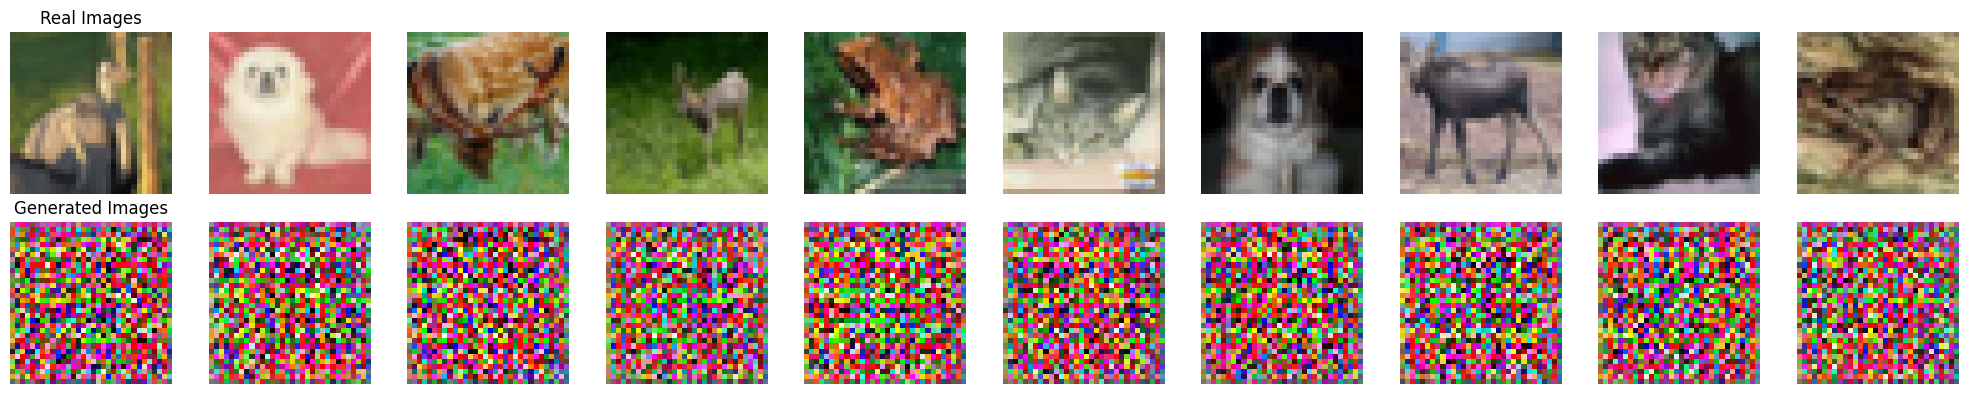

 FID : 547.9599327559584
Training started...
[Epoch 1/50] Loss D: -0.0058, Loss G: -0.0064 , FID score : 225.9982
[Epoch 2/50] Loss D: -0.0073, Loss G: -0.0059 , FID score : 228.7919
[Epoch 3/50] Loss D: -0.0075, Loss G: -0.0059 , FID score : 211.2342
[Epoch 4/50] Loss D: -0.0074, Loss G: -0.0059 , FID score : 204.7221
[Epoch 5/50] Loss D: -0.0074, Loss G: -0.0059 , FID score : 199.6699
[Epoch 6/50] Loss D: -0.0074, Loss G: -0.0059 , FID score : 182.2604
[Epoch 7/50] Loss D: -0.0074, Loss G: -0.0059 , FID score : 207.1487
[Epoch 8/50] Loss D: -0.0074, Loss G: -0.0059 , FID score : 181.7236
[Epoch 9/50] Loss D: -0.0074, Loss G: -0.0060 , FID score : 171.1869
[Epoch 10/50] Loss D: -0.0073, Loss G: -0.0060 , FID score : 161.9078
[Epoch 11/50] Loss D: -0.0072, Loss G: -0.0060 , FID score : 145.0708
[Epoch 12/50] Loss D: -0.0072, Loss G: -0.0060 , FID score : 154.2754
[Epoch 13/50] Loss D: -0.0071, Loss G: -0.0059 , FID score : 151.4598
[Epoch 14/50] Loss D: -0.0072, Loss G: -0.0059 , FID s

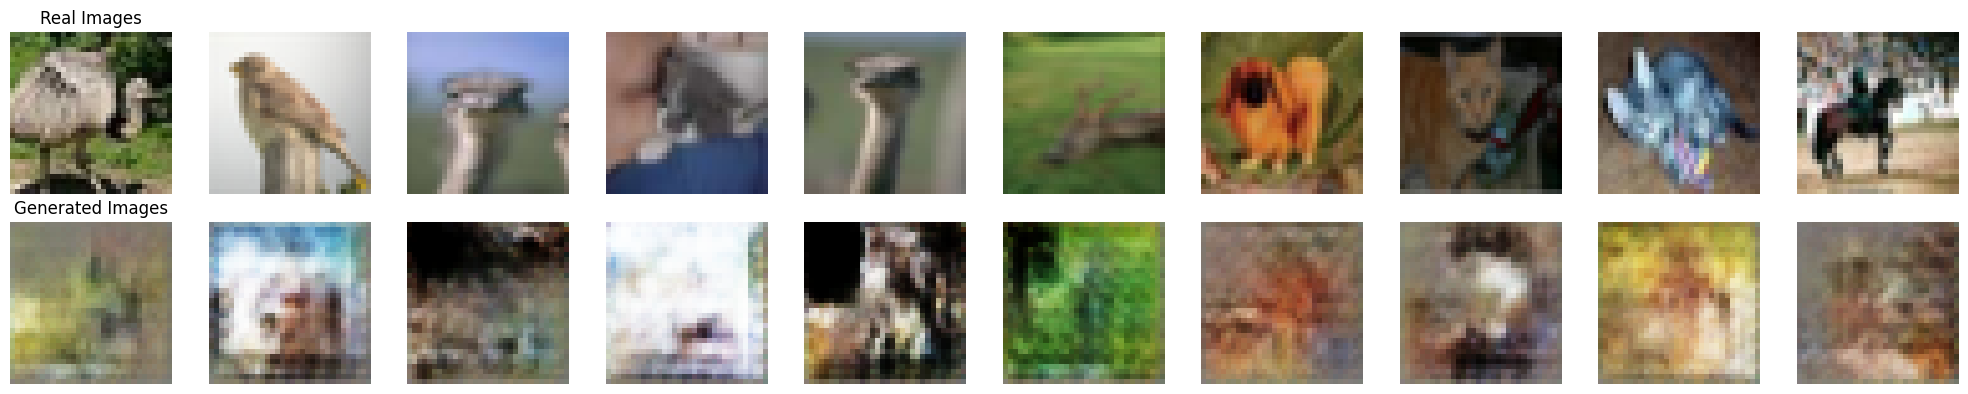

[Epoch 26/50] Loss D: -0.0065, Loss G: -0.0063 , FID score : 111.8048
[Epoch 27/50] Loss D: -0.0065, Loss G: -0.0063 , FID score : 115.6928
[Epoch 28/50] Loss D: -0.0064, Loss G: -0.0063 , FID score : 113.0827
[Epoch 29/50] Loss D: -0.0064, Loss G: -0.0064 , FID score : 106.6114
[Epoch 30/50] Loss D: -0.0063, Loss G: -0.0064 , FID score : 106.4017
[Epoch 31/50] Loss D: -0.0062, Loss G: -0.0065 , FID score : 102.7830
[Epoch 32/50] Loss D: -0.0062, Loss G: -0.0064 , FID score : 100.0603
[Epoch 33/50] Loss D: -0.0060, Loss G: -0.0065 , FID score : 96.9517
[Epoch 34/50] Loss D: -0.0061, Loss G: -0.0065 , FID score : 93.8665
[Epoch 35/50] Loss D: -0.0060, Loss G: -0.0065 , FID score : 92.8415
[Epoch 36/50] Loss D: -0.0058, Loss G: -0.0066 , FID score : 92.2498
[Epoch 37/50] Loss D: -0.0059, Loss G: -0.0065 , FID score : 90.3420
[Epoch 38/50] Loss D: -0.0058, Loss G: -0.0066 , FID score : 89.5954
[Epoch 39/50] Loss D: -0.0058, Loss G: -0.0066 , FID score : 89.8641
[Epoch 40/50] Loss D: -0.00

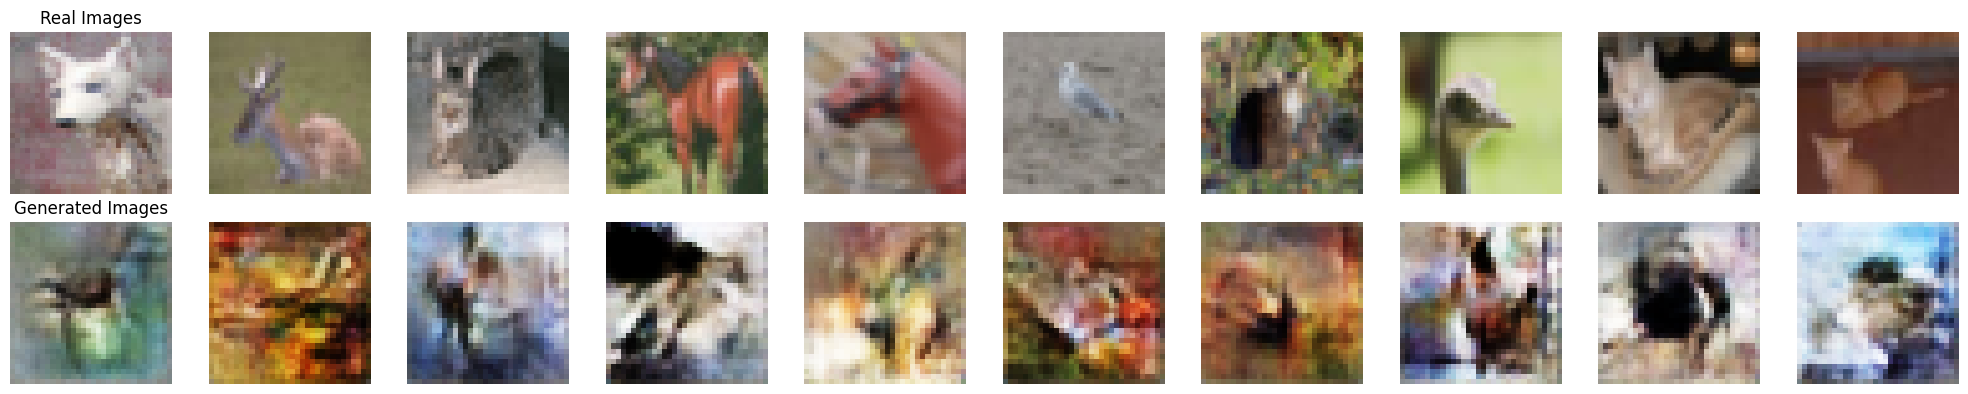

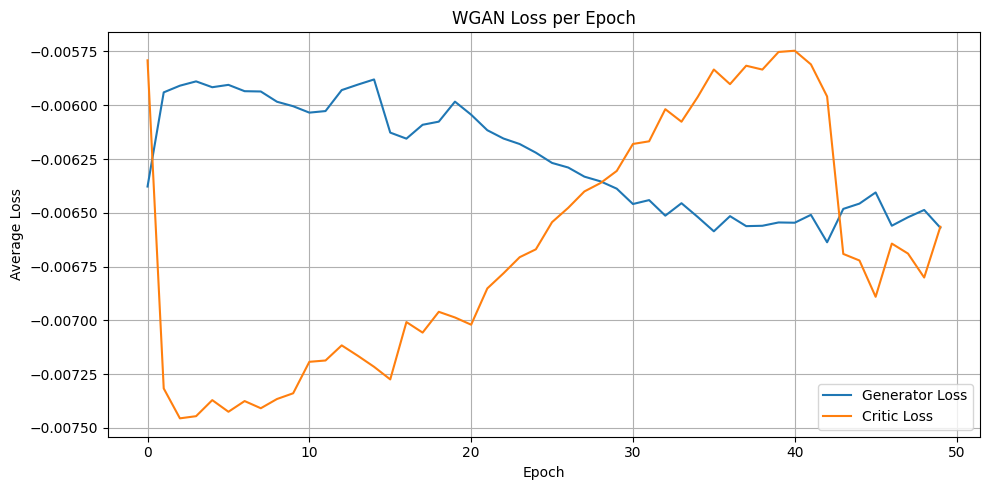

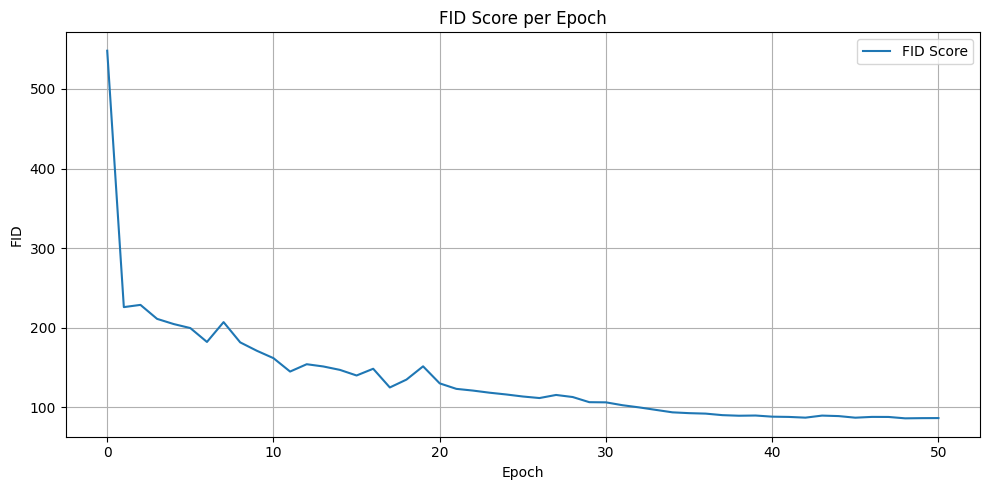

In [23]:
generator_8 = Generator_2(latent_dim).to(device)
critic_8 = Critic_3().to(device)
optimizer_g8 = optim.RMSprop(generator_8.parameters(), lr=lr)
optimizer_c8 = optim.RMSprop(critic_8.parameters(), lr=lr)

with torch.no_grad():
    noise = torch.randn(10, latent_dim).to(device)
    gen_imgs = generator_8(noise)

# Get real images for comparison
for imgs, _ in dataloader:
    real_imgs = imgs.to(device)
    break
print("Before Training...")
val = evaluate_fid(generator_8, dataloader, 5000 , 100 , latent_dim, device)
show_imgs(real_imgs, gen_imgs, n=10)
print(f" FID : {val}")
print("Training started...")

# Start training
fid_8 = train_WGAN(generator_8, critic_8, optimizer_g8, optimizer_c8, dataloader, device, latent_dim, n_critic , c , n_epochs , val)

**OBSERVATION_8**

1. The box / grid pattern on the output can be caused by Maxpool 
2. Overall Sharp Structure may be caused by ConvTranspose Layer
3. Loss curves behaves oddly 
4. FID scores is better but not the best showing convergence has occured but not good in nature 

Before Training...


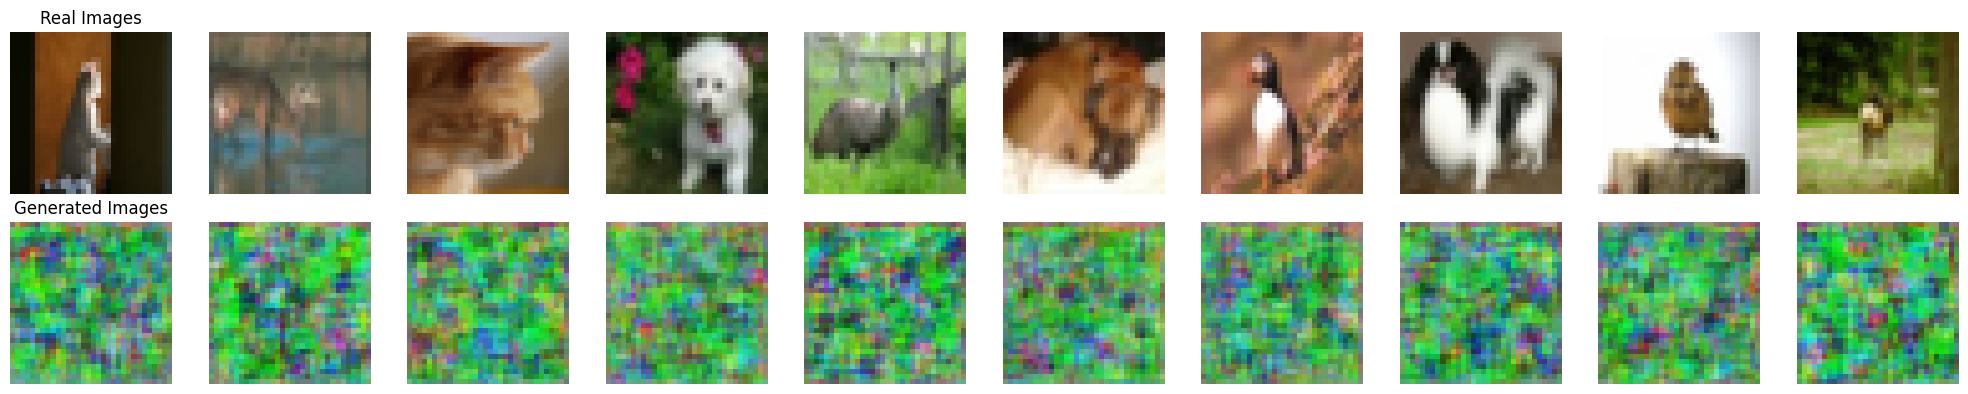

 FID : 437.2278270149885
Training started...
[Epoch 1/50] Loss D: -0.0018, Loss G: 0.0102 , FID score : 218.6458
[Epoch 2/50] Loss D: -0.0028, Loss G: 0.0108 , FID score : 148.0335
[Epoch 3/50] Loss D: -0.0025, Loss G: 0.0107 , FID score : 169.9500
[Epoch 4/50] Loss D: -0.0025, Loss G: 0.0107 , FID score : 137.8713
[Epoch 5/50] Loss D: -0.0030, Loss G: 0.0109 , FID score : 127.8047
[Epoch 6/50] Loss D: -0.0027, Loss G: 0.0109 , FID score : 131.5995
[Epoch 7/50] Loss D: -0.0025, Loss G: 0.0107 , FID score : 124.8587
[Epoch 8/50] Loss D: -0.0023, Loss G: 0.0106 , FID score : 116.4143
[Epoch 9/50] Loss D: -0.0022, Loss G: 0.0106 , FID score : 109.2447
[Epoch 10/50] Loss D: -0.0022, Loss G: 0.0106 , FID score : 104.0688
[Epoch 11/50] Loss D: -0.0021, Loss G: 0.0105 , FID score : 95.6969
[Epoch 12/50] Loss D: -0.0020, Loss G: 0.0104 , FID score : 94.7858
[Epoch 13/50] Loss D: -0.0020, Loss G: 0.0105 , FID score : 87.7042
[Epoch 14/50] Loss D: -0.0019, Loss G: 0.0104 , FID score : 91.2106
[E

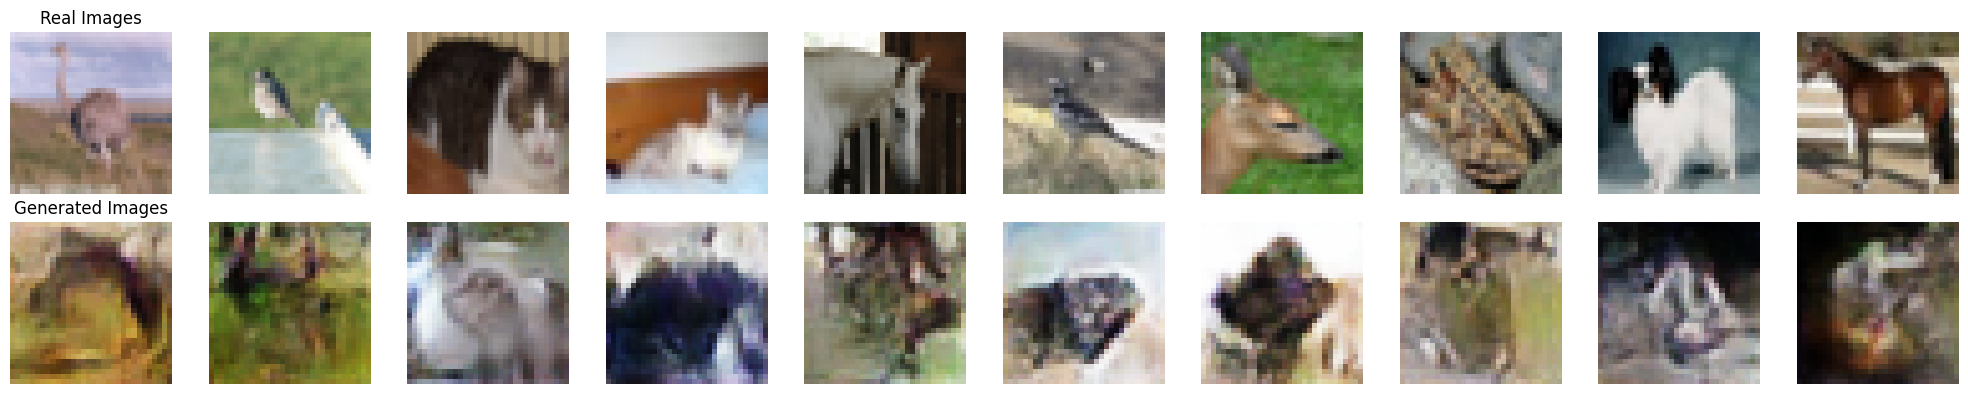

[Epoch 26/50] Loss D: -0.0015, Loss G: 0.0102 , FID score : 74.8885
[Epoch 27/50] Loss D: -0.0015, Loss G: 0.0103 , FID score : 72.1204
[Epoch 28/50] Loss D: -0.0015, Loss G: 0.0102 , FID score : 73.2937
[Epoch 29/50] Loss D: -0.0015, Loss G: 0.0101 , FID score : 70.7003
[Epoch 30/50] Loss D: -0.0015, Loss G: 0.0102 , FID score : 69.7686
[Epoch 31/50] Loss D: -0.0014, Loss G: 0.0102 , FID score : 69.6898
[Epoch 32/50] Loss D: -0.0014, Loss G: 0.0102 , FID score : 67.2669
[Epoch 33/50] Loss D: -0.0014, Loss G: 0.0101 , FID score : 68.0540
[Epoch 34/50] Loss D: -0.0014, Loss G: 0.0101 , FID score : 66.4665
[Epoch 35/50] Loss D: -0.0013, Loss G: 0.0102 , FID score : 68.4630
[Epoch 36/50] Loss D: -0.0013, Loss G: 0.0103 , FID score : 70.0739
[Epoch 37/50] Loss D: -0.0013, Loss G: 0.0101 , FID score : 65.5216
[Epoch 38/50] Loss D: -0.0013, Loss G: 0.0101 , FID score : 68.8291
[Epoch 39/50] Loss D: -0.0013, Loss G: 0.0101 , FID score : 65.8500
[Epoch 40/50] Loss D: -0.0013, Loss G: 0.0102 , 

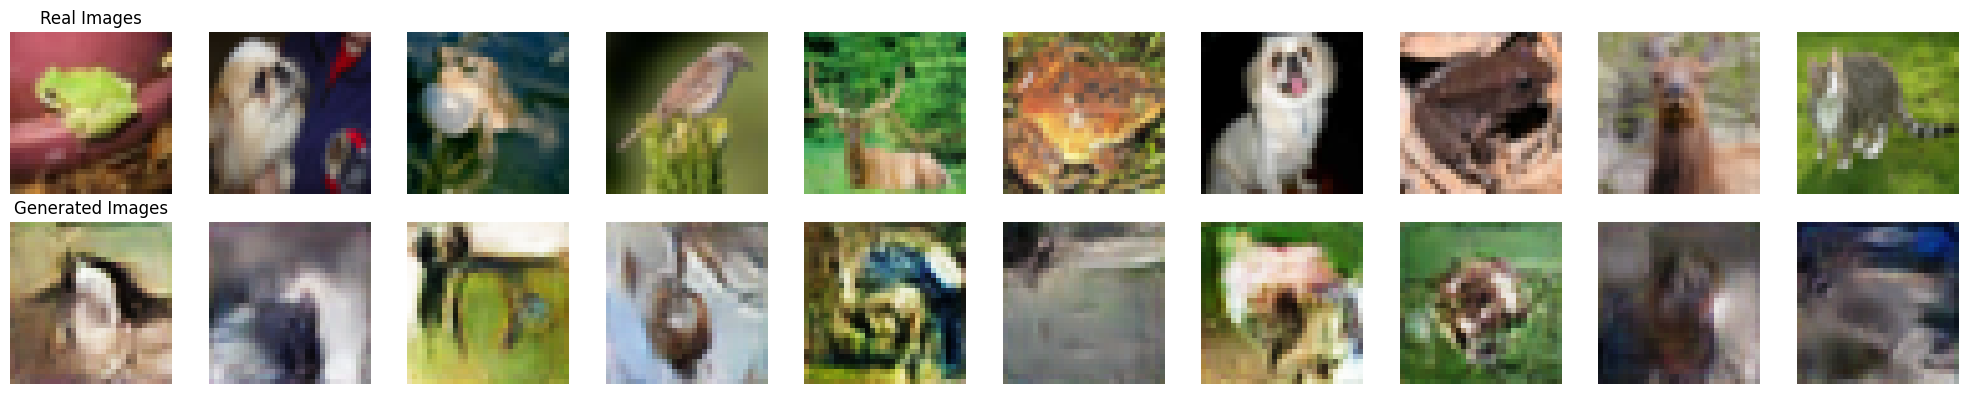

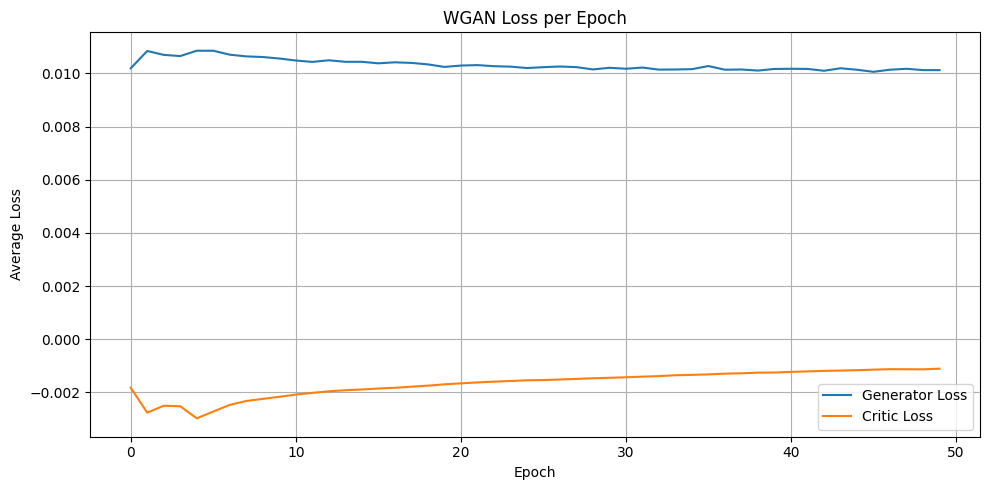

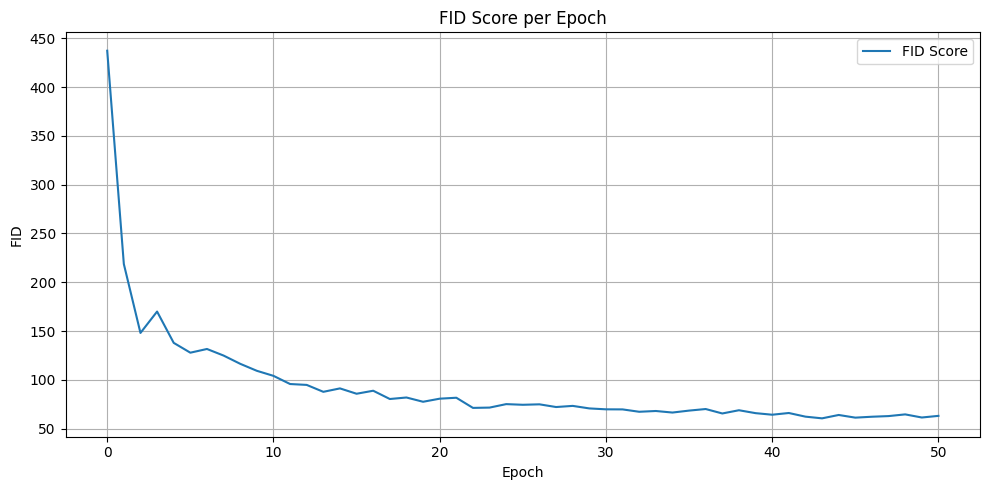

In [24]:
generator_7 = Generator_3(latent_dim).to(device)
critic_7 = Critic_2().to(device)
optimizer_g7 = optim.RMSprop(generator_7.parameters(), lr=lr)
optimizer_c7 = optim.RMSprop(critic_7.parameters(), lr=lr)

with torch.no_grad():
    noise = torch.randn(10, latent_dim).to(device)
    gen_imgs = generator_7(noise)

# Get real images for comparison
for imgs, _ in dataloader:
    real_imgs = imgs.to(device)
    break
    
print("Before Training...")
val = evaluate_fid(generator_7, dataloader, 5000 , 100 , latent_dim, device)
show_imgs(real_imgs, gen_imgs, n=10)
print(f" FID : {val}")
print("Training started...")

# Start training
fid_7 = train_WGAN(generator_7, critic_7, optimizer_g7, optimizer_c7, dataloader, device, latent_dim, n_critic , c , n_epochs , val)

**OBSERVATION_7**

1. Generator 3 again performs better 
2. The results are little bit away from the past outcomes and early saturatopn of critc 2 can be seen it as Weaker Critic in nature 
3. Weaker critic is not Training the generator well so a strong Critic is required  

In [15]:
class Generator_7(nn.Module):
    def __init__(self, latent_dim=100):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 512*4*4),
            nn.ReLU(),
            nn.Unflatten(1, (512, 4, 4)),
            
            nn.ConvTranspose2d(512, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.ConvTranspose2d(128, 3, 4, 2, 1),
            nn.Tanh()
        )
        
    def forward(self, z):
        return self.model(z)

generator = Generator_7().to(device)
print(Summary(generator, input_size=(latent_dim,), batch_size=batch_size, device="cuda"))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [64, 8192]         827,392
              ReLU-2                 [64, 8192]               0
         Unflatten-3            [64, 512, 4, 4]               0
   ConvTranspose2d-4            [64, 256, 8, 8]       2,097,408
       BatchNorm2d-5            [64, 256, 8, 8]             512
              ReLU-6            [64, 256, 8, 8]               0
   ConvTranspose2d-7          [64, 128, 16, 16]         524,416
       BatchNorm2d-8          [64, 128, 16, 16]             256
              ReLU-9          [64, 128, 16, 16]               0
  ConvTranspose2d-10            [64, 3, 32, 32]           6,147
             Tanh-11            [64, 3, 32, 32]               0
Total params: 3,456,131
Trainable params: 3,456,131
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forw

In [20]:
class Critic_6(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
            # Input: 3 x 32 x 32
            nn.Conv2d(3, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.2),
            # 64 x 16 x 16
            
            nn.Conv2d(128,512 , kernel_size=4, stride=2, padding=1, bias=False),
            nn.LayerNorm([512, 8, 8]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.2),
            # 128 x 8 x 8
            
            nn.Conv2d(512,1024, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LayerNorm([1024,4,4]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.2),
            # 256 x 4 x 4
            
            # Global average pooling instead of another conv layer
            nn.AdaptiveAvgPool2d(1),  # 256 x 1 x 1
            nn.Flatten(),
            nn.Linear(1024, 1)
        )

    def forward(self, x):
        return self.model(x)

critic = Critic_6().to(device)
print(Summary(critic, (3, 32, 32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 16, 16]           6,144
         LeakyReLU-2          [-1, 128, 16, 16]               0
         Dropout2d-3          [-1, 128, 16, 16]               0
            Conv2d-4            [-1, 512, 8, 8]       1,048,576
         LayerNorm-5            [-1, 512, 8, 8]          65,536
         LeakyReLU-6            [-1, 512, 8, 8]               0
         Dropout2d-7            [-1, 512, 8, 8]               0
            Conv2d-8           [-1, 1024, 4, 4]       8,388,608
         LayerNorm-9           [-1, 1024, 4, 4]          32,768
        LeakyReLU-10           [-1, 1024, 4, 4]               0
        Dropout2d-11           [-1, 1024, 4, 4]               0
AdaptiveAvgPool2d-12           [-1, 1024, 1, 1]               0
          Flatten-13                 [-1, 1024]               0
           Linear-14                   

Before Training...


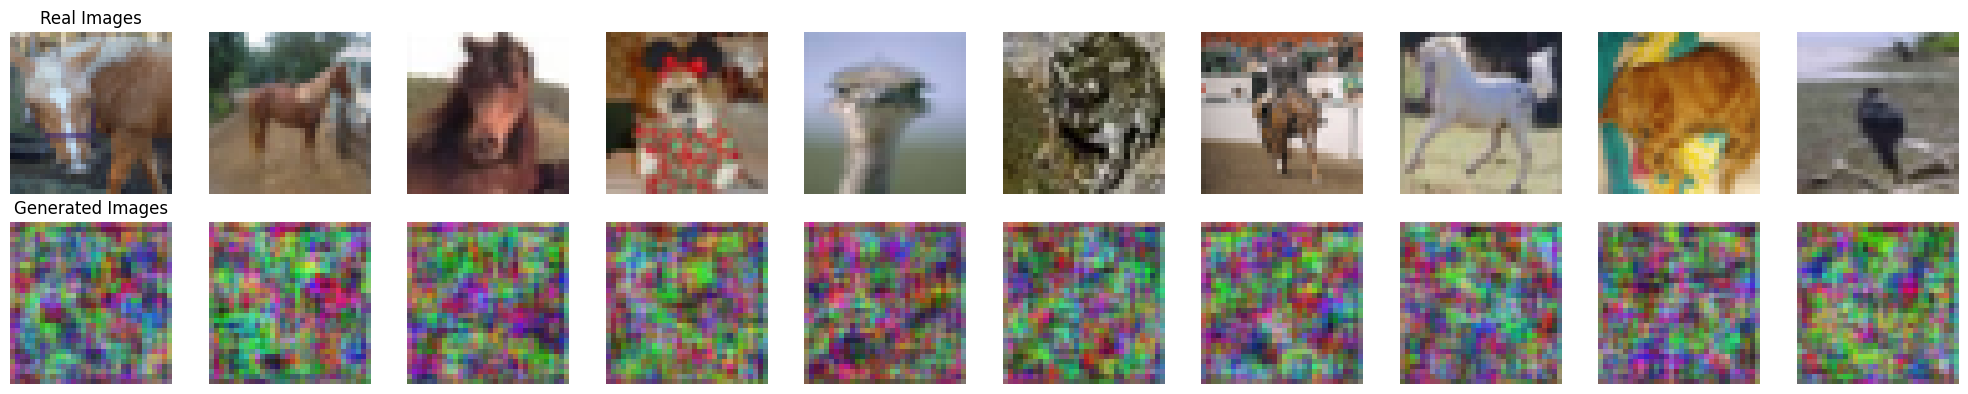

 FID : 383.29586210591145
Training started...
[Epoch 1/50] Loss D: -0.1114, Loss G: 0.0713 , FID score : 181.5042
[Epoch 2/50] Loss D: -0.1104, Loss G: 0.0684 , FID score : 142.3714
[Epoch 3/50] Loss D: -0.1157, Loss G: 0.0709 , FID score : 124.4823
[Epoch 4/50] Loss D: -0.1185, Loss G: 0.0721 , FID score : 108.9991
[Epoch 5/50] Loss D: -0.1170, Loss G: 0.0720 , FID score : 104.8995
[Epoch 6/50] Loss D: -0.1141, Loss G: 0.0705 , FID score : 105.7036
[Epoch 7/50] Loss D: -0.1108, Loss G: 0.0682 , FID score : 95.8399
[Epoch 8/50] Loss D: -0.1073, Loss G: 0.0671 , FID score : 97.9284
[Epoch 9/50] Loss D: -0.1041, Loss G: 0.0653 , FID score : 91.5688
[Epoch 10/50] Loss D: -0.1010, Loss G: 0.0631 , FID score : 89.8746
[Epoch 11/50] Loss D: -0.0980, Loss G: 0.0618 , FID score : 88.0782
[Epoch 12/50] Loss D: -0.0952, Loss G: 0.0599 , FID score : 87.8780
[Epoch 13/50] Loss D: -0.0923, Loss G: 0.0590 , FID score : 86.5922
[Epoch 14/50] Loss D: -0.0894, Loss G: 0.0583 , FID score : 81.6344
[Epoc

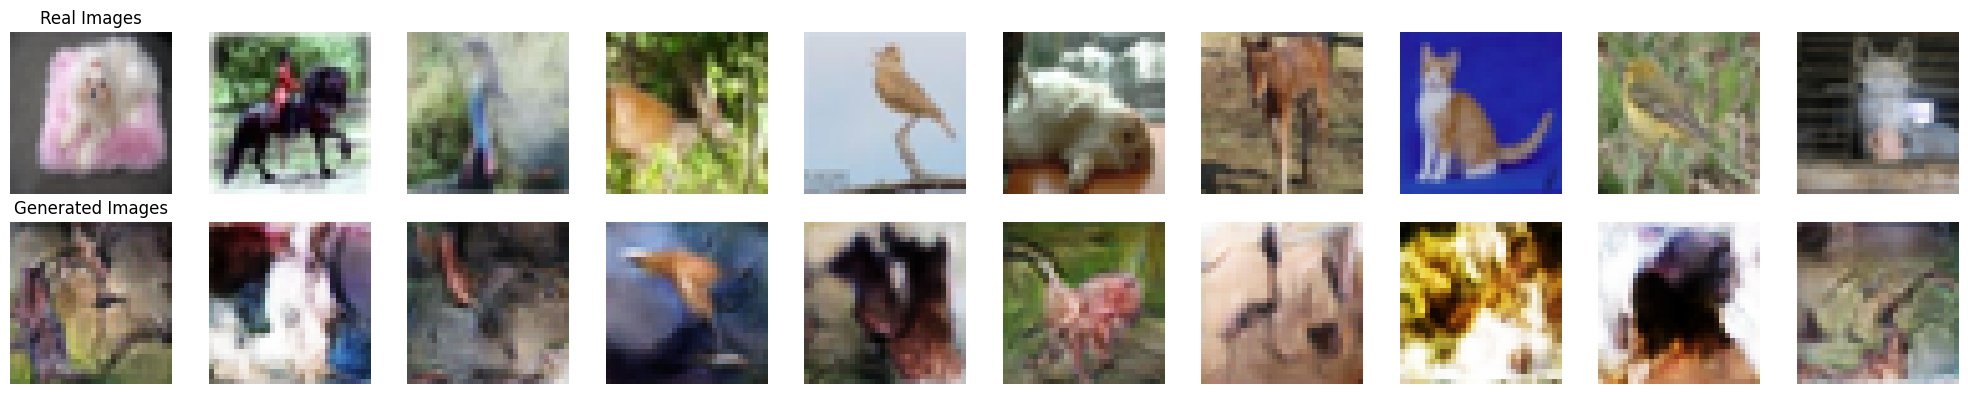

[Epoch 26/50] Loss D: -0.0693, Loss G: 0.0475 , FID score : 71.9269
[Epoch 27/50] Loss D: -0.0683, Loss G: 0.0469 , FID score : 71.7571
[Epoch 28/50] Loss D: -0.0676, Loss G: 0.0472 , FID score : 67.8720
[Epoch 29/50] Loss D: -0.0665, Loss G: 0.0457 , FID score : 66.9887
[Epoch 30/50] Loss D: -0.0657, Loss G: 0.0452 , FID score : 68.3215
[Epoch 31/50] Loss D: -0.0649, Loss G: 0.0450 , FID score : 67.6587
[Epoch 32/50] Loss D: -0.0642, Loss G: 0.0448 , FID score : 69.4178
[Epoch 33/50] Loss D: -0.0635, Loss G: 0.0439 , FID score : 67.1021
[Epoch 34/50] Loss D: -0.0630, Loss G: 0.0436 , FID score : 64.6722
[Epoch 35/50] Loss D: -0.0622, Loss G: 0.0441 , FID score : 63.8036
[Epoch 36/50] Loss D: -0.0617, Loss G: 0.0434 , FID score : 62.2265
[Epoch 37/50] Loss D: -0.0608, Loss G: 0.0422 , FID score : 64.0905
[Epoch 38/50] Loss D: -0.0605, Loss G: 0.0419 , FID score : 61.4908
[Epoch 39/50] Loss D: -0.0599, Loss G: 0.0416 , FID score : 61.9080
[Epoch 40/50] Loss D: -0.0593, Loss G: 0.0424 , 

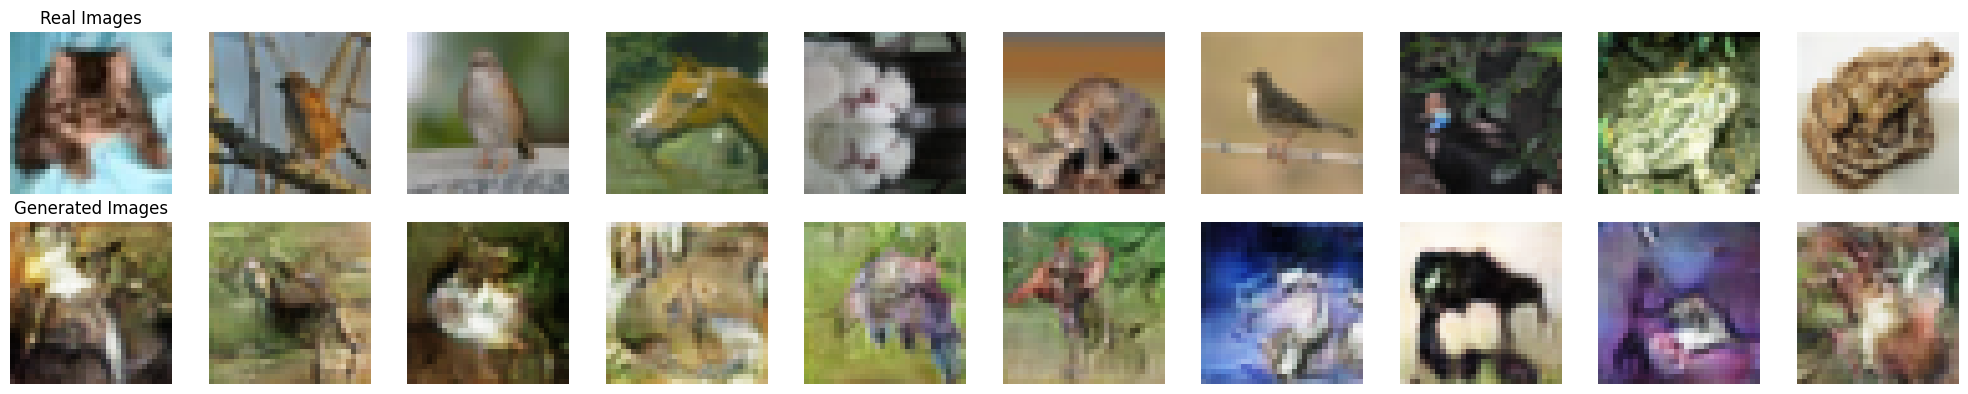

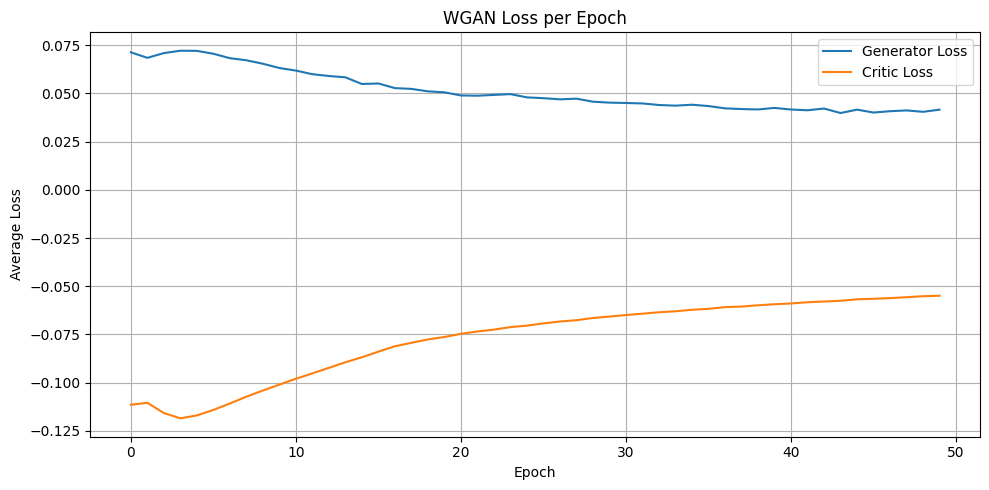

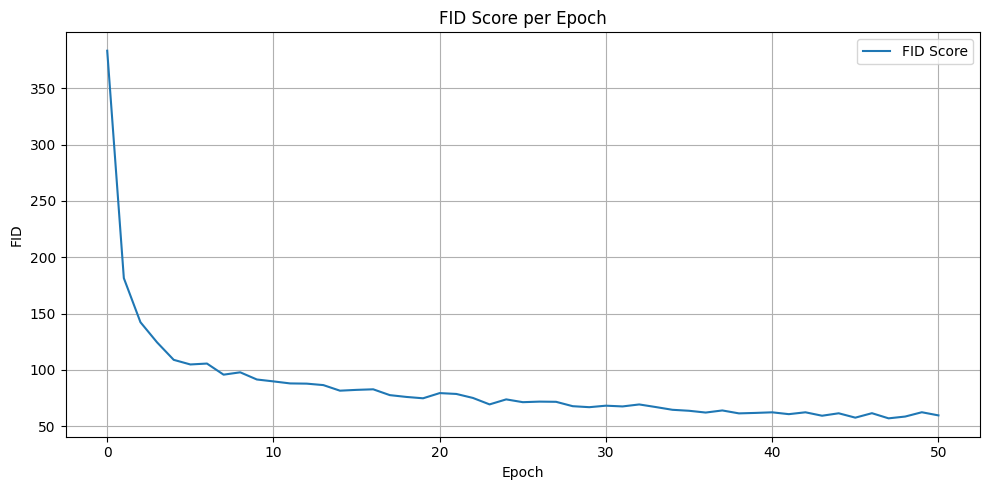

In [29]:
generator_6 = Generator_3(latent_dim).to(device)
critic_6 = Critic_6().to(device)
optimizer_g6 = optim.RMSprop(generator_6.parameters(), lr=lr)
optimizer_c6 = optim.RMSprop(critic_6.parameters(), lr=lr)

with torch.no_grad():
    noise = torch.randn(10, latent_dim).to(device)
    gen_imgs = generator_6(noise)

# Get real images for comparison
for imgs, _ in dataloader:
    real_imgs = imgs.to(device)
    break
    
print("Before Training...")
val = evaluate_fid(generator_6, dataloader, 5000 , 100 , latent_dim, device)
show_imgs(real_imgs, gen_imgs, n=10)
print(f" FID : {val}")
print("Training started...")

# Start training
fid_6 = train_WGAN(generator_6, critic_6, optimizer_g6, optimizer_c6, dataloader, device, latent_dim, n_critic , c , n_epochs , val)

**OBSERVATION_6**

1. Critic is 6 is much stronger in nature with 9.5 million parameters 
2. Stronger Critc trainging the generator well so it again touched its previous results
3. Both the Loss Curves are steadily increasing which signifies a healthy training and with Longer epochs Convergence can be better
4. The heavy Critic Can take more computational cost to train
5. Adding regualarization in the form of Dropouts sre doing well

Before Training...


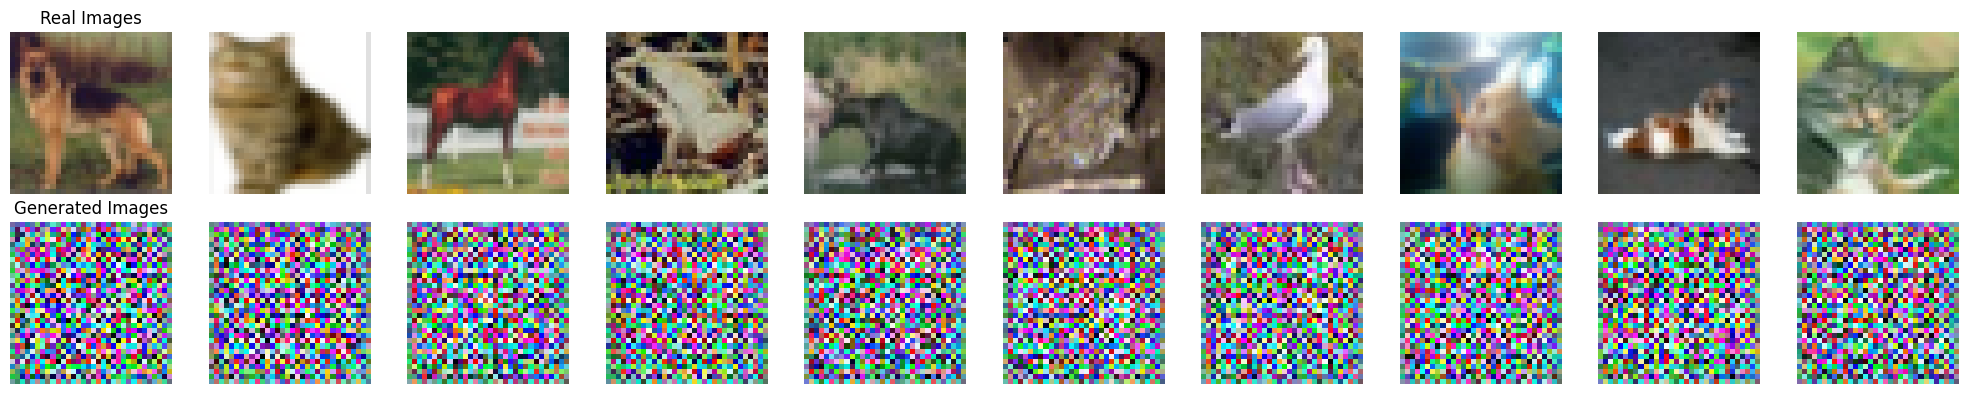

 FID : 471.0425191470089
Training started...
[Epoch 1/50] Loss D: -0.1922, Loss G: 0.0936 , FID score : 406.8330
[Epoch 2/50] Loss D: -0.2004, Loss G: 0.0964 , FID score : 302.0173
[Epoch 3/50] Loss D: -0.2010, Loss G: 0.0970 , FID score : 267.5749
[Epoch 4/50] Loss D: -0.1991, Loss G: 0.0970 , FID score : 220.3028
[Epoch 5/50] Loss D: -0.1988, Loss G: 0.0965 , FID score : 231.0402
[Epoch 6/50] Loss D: -0.1955, Loss G: 0.0958 , FID score : 211.5705
[Epoch 7/50] Loss D: -0.1952, Loss G: 0.0952 , FID score : 221.9064
[Epoch 8/50] Loss D: -0.1930, Loss G: 0.0946 , FID score : 227.3545
[Epoch 9/50] Loss D: -0.1906, Loss G: 0.0935 , FID score : 195.2605
[Epoch 10/50] Loss D: -0.1890, Loss G: 0.0926 , FID score : 193.6077
[Epoch 11/50] Loss D: -0.1872, Loss G: 0.0922 , FID score : 173.2809
[Epoch 12/50] Loss D: -0.1848, Loss G: 0.0911 , FID score : 183.2497
[Epoch 13/50] Loss D: -0.1863, Loss G: 0.0907 , FID score : 170.2880
[Epoch 14/50] Loss D: -0.1870, Loss G: 0.0916 , FID score : 159.295

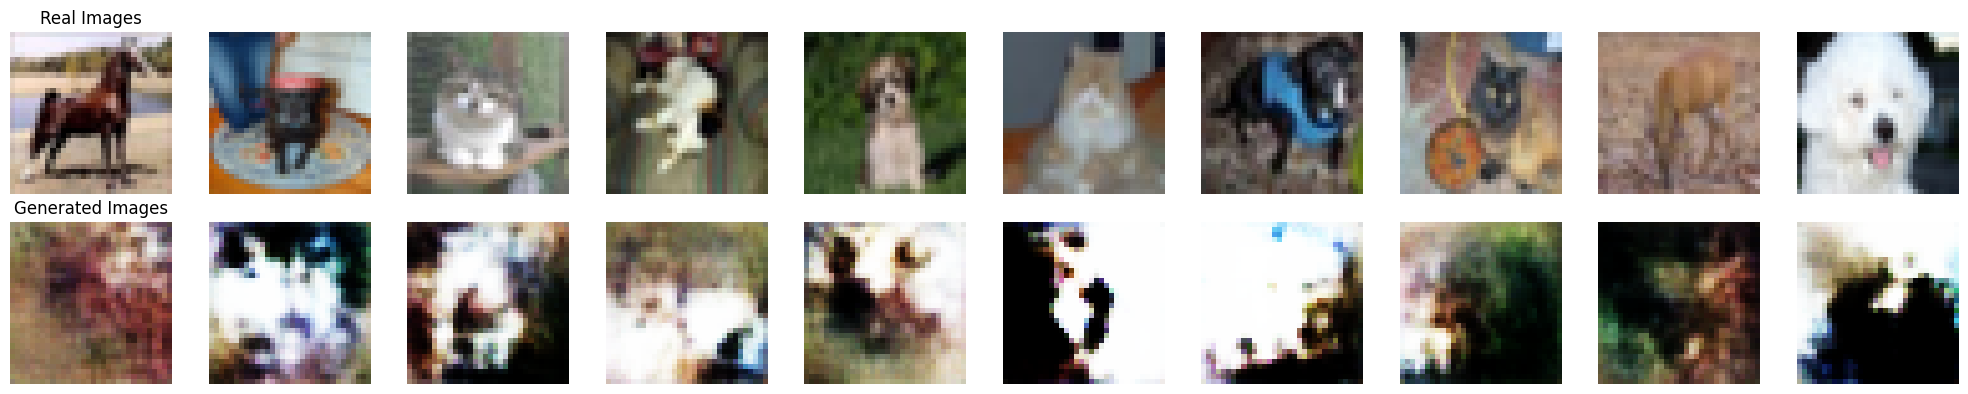

[Epoch 26/50] Loss D: -0.1864, Loss G: 0.0900 , FID score : 155.4697
[Epoch 27/50] Loss D: -0.1834, Loss G: 0.0886 , FID score : 141.4464
[Epoch 28/50] Loss D: -0.1825, Loss G: 0.0874 , FID score : 143.3132
[Epoch 29/50] Loss D: -0.1836, Loss G: 0.0886 , FID score : 144.8774
[Epoch 30/50] Loss D: -0.1856, Loss G: 0.0892 , FID score : 156.3090
[Epoch 31/50] Loss D: -0.1832, Loss G: 0.0882 , FID score : 140.0361
[Epoch 32/50] Loss D: -0.1811, Loss G: 0.0872 , FID score : 141.4683
[Epoch 33/50] Loss D: -0.1809, Loss G: 0.0867 , FID score : 139.7657
[Epoch 34/50] Loss D: -0.1807, Loss G: 0.0867 , FID score : 149.5889
[Epoch 35/50] Loss D: -0.1777, Loss G: 0.0860 , FID score : 139.7211
[Epoch 36/50] Loss D: -0.1781, Loss G: 0.0860 , FID score : 136.7613
[Epoch 37/50] Loss D: -0.1749, Loss G: 0.0852 , FID score : 157.2977
[Epoch 38/50] Loss D: -0.1758, Loss G: 0.0842 , FID score : 140.7850
[Epoch 39/50] Loss D: -0.1763, Loss G: 0.0839 , FID score : 137.5151
[Epoch 40/50] Loss D: -0.1735, Los

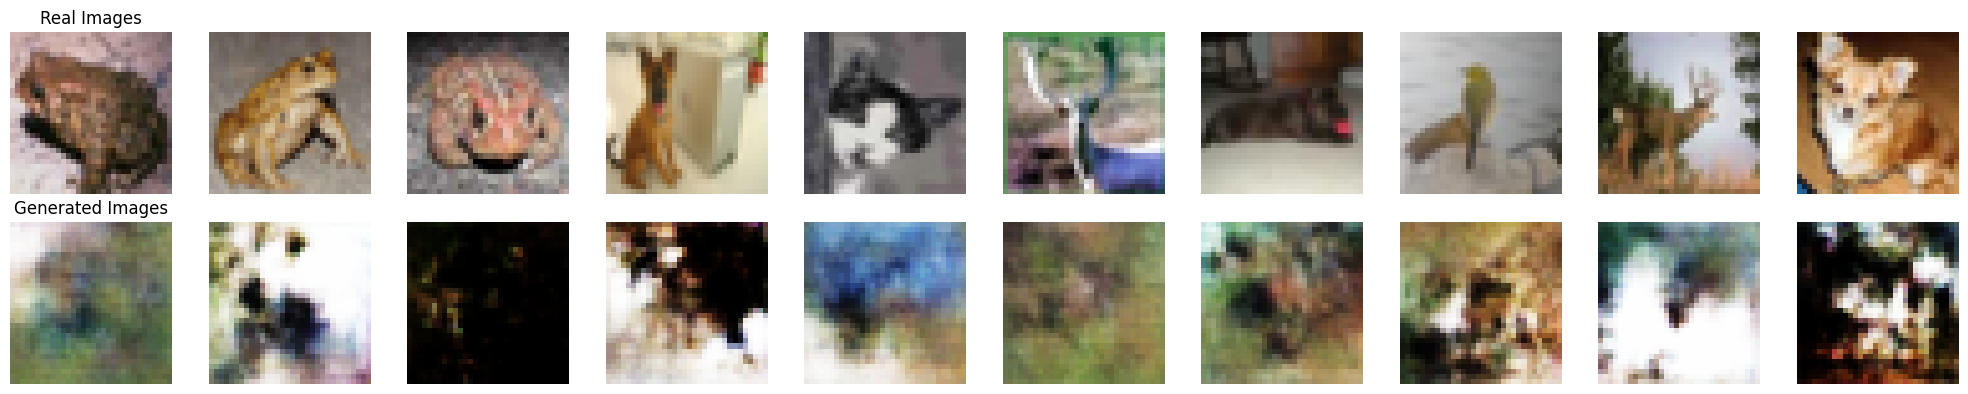

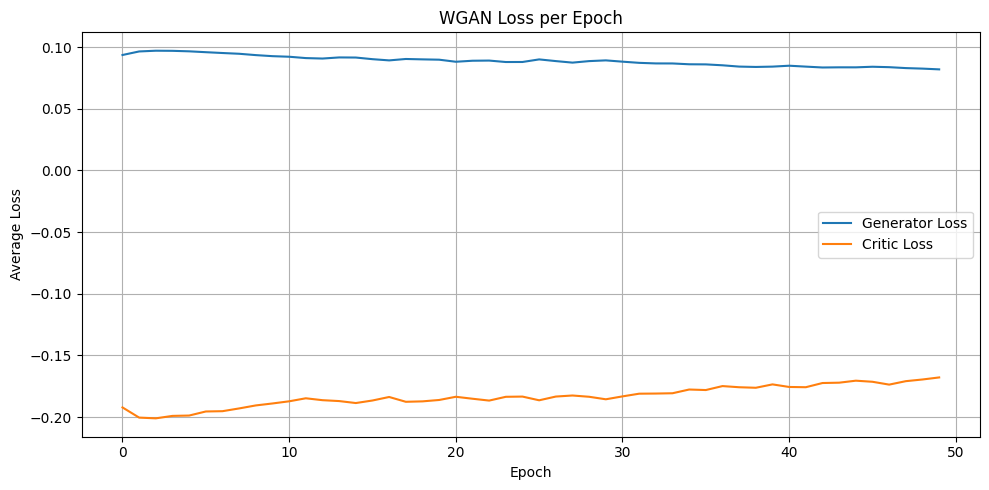

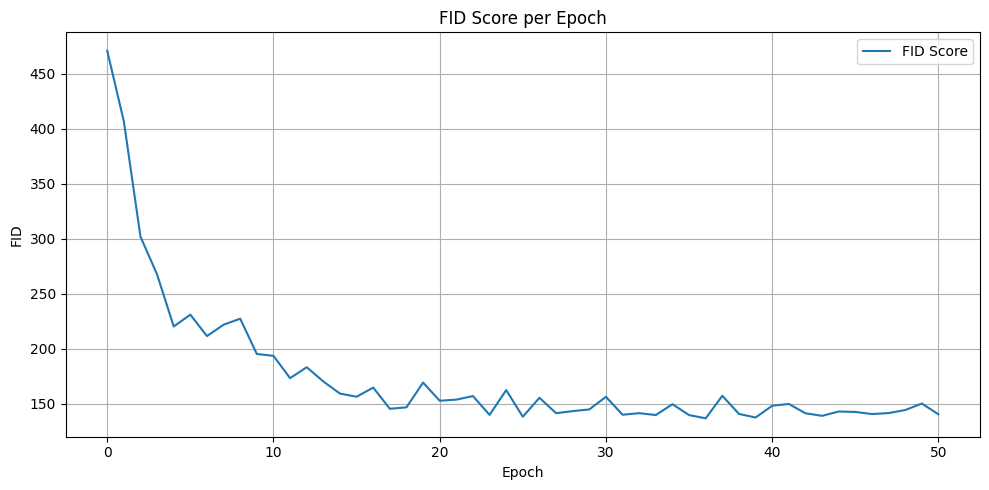

In [21]:
generator_9 = Generator_7(latent_dim).to(device)
critic_9 = Critic_6().to(device)
optimizer_g9 = optim.RMSprop(generator_9.parameters(), lr=lr)
optimizer_c9 = optim.RMSprop(critic_9.parameters(), lr=lr)

with torch.no_grad():
    noise = torch.randn(10, latent_dim).to(device)
    gen_imgs = generator_9(noise)

# Get real images for comparison
for imgs, _ in dataloader:
    real_imgs = imgs.to(device)
    break
    
print("Before Training...")
val = evaluate_fid(generator_9, dataloader, 5000 , 100 , latent_dim, device)
show_imgs(real_imgs, gen_imgs, n=10)
print(f" FID : {val}")
print("Training started...")

# Start training
fid_9 = train_WGAN(generator_9, critic_9, optimizer_g9, optimizer_c9, dataloader, device, latent_dim, n_critic , c , n_epochs , val)

**OSERVATION_9**

1. A mixture of 2nd and 3rd Generator ( As Generator_7 -- to better the ConvTranspose Activity ) has been tested with this stronger critic but it collapsed
2. Very slow increase in Loss Curve
3. Poor Fid with Flactuation


In [23]:
class Critic_7(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
            # Input: 3 x 32 x 32
            nn.Conv2d(3, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.2),
            # 64 x 16 x 16
            
            nn.Conv2d(128,256 , kernel_size=4, stride=2, padding=1, bias=False),
            nn.LayerNorm([256, 8, 8]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.2),
            # 128 x 8 x 8
            
            nn.Conv2d(256,512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LayerNorm([512,4,4]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.2),
            # 256 x 4 x 4
            
            # Global average pooling instead of another conv layer
            nn.AdaptiveAvgPool2d(1),  # 256 x 1 x 1
            nn.Flatten(),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        return self.model(x)

critic = Critic_7().to(device)
print(Summary(critic, (3, 32, 32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 16, 16]           6,144
         LeakyReLU-2          [-1, 128, 16, 16]               0
         Dropout2d-3          [-1, 128, 16, 16]               0
            Conv2d-4            [-1, 256, 8, 8]         524,288
         LayerNorm-5            [-1, 256, 8, 8]          32,768
         LeakyReLU-6            [-1, 256, 8, 8]               0
         Dropout2d-7            [-1, 256, 8, 8]               0
            Conv2d-8            [-1, 512, 4, 4]       2,097,152
         LayerNorm-9            [-1, 512, 4, 4]          16,384
        LeakyReLU-10            [-1, 512, 4, 4]               0
        Dropout2d-11            [-1, 512, 4, 4]               0
AdaptiveAvgPool2d-12            [-1, 512, 1, 1]               0
          Flatten-13                  [-1, 512]               0
           Linear-14                   

Before Training...


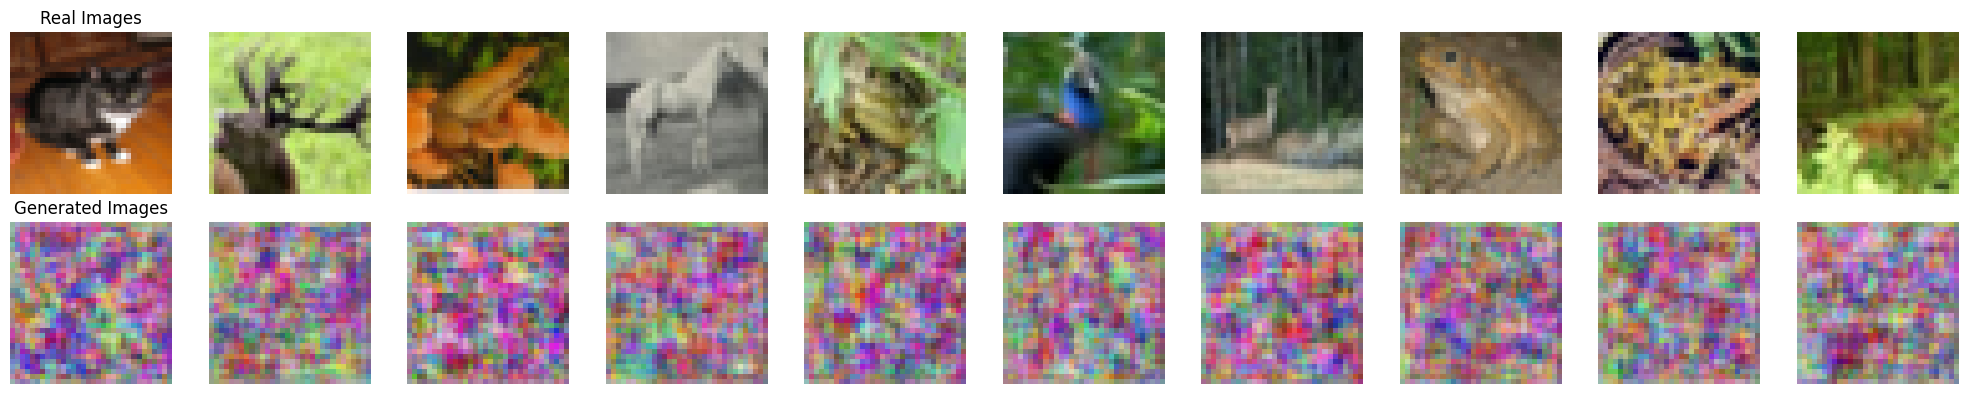

 FID : 432.3595224110757
Training started...
[Epoch 1/50] Loss D: -0.0524, Loss G: 0.0413 , FID score : 189.4848
[Epoch 2/50] Loss D: -0.0536, Loss G: 0.0415 , FID score : 131.6926
[Epoch 3/50] Loss D: -0.0541, Loss G: 0.0414 , FID score : 115.5067
[Epoch 4/50] Loss D: -0.0538, Loss G: 0.0404 , FID score : 108.4557
[Epoch 5/50] Loss D: -0.0495, Loss G: 0.0388 , FID score : 105.8299
[Epoch 6/50] Loss D: -0.0470, Loss G: 0.0378 , FID score : 100.2972
[Epoch 7/50] Loss D: -0.0454, Loss G: 0.0367 , FID score : 96.9632
[Epoch 8/50] Loss D: -0.0437, Loss G: 0.0357 , FID score : 98.1413
[Epoch 9/50] Loss D: -0.0422, Loss G: 0.0348 , FID score : 91.3975
[Epoch 10/50] Loss D: -0.0406, Loss G: 0.0346 , FID score : 92.4981
[Epoch 11/50] Loss D: -0.0391, Loss G: 0.0340 , FID score : 87.7161
[Epoch 12/50] Loss D: -0.0379, Loss G: 0.0322 , FID score : 87.0100
[Epoch 13/50] Loss D: -0.0367, Loss G: 0.0322 , FID score : 85.5150
[Epoch 14/50] Loss D: -0.0358, Loss G: 0.0318 , FID score : 82.4520
[Epoch

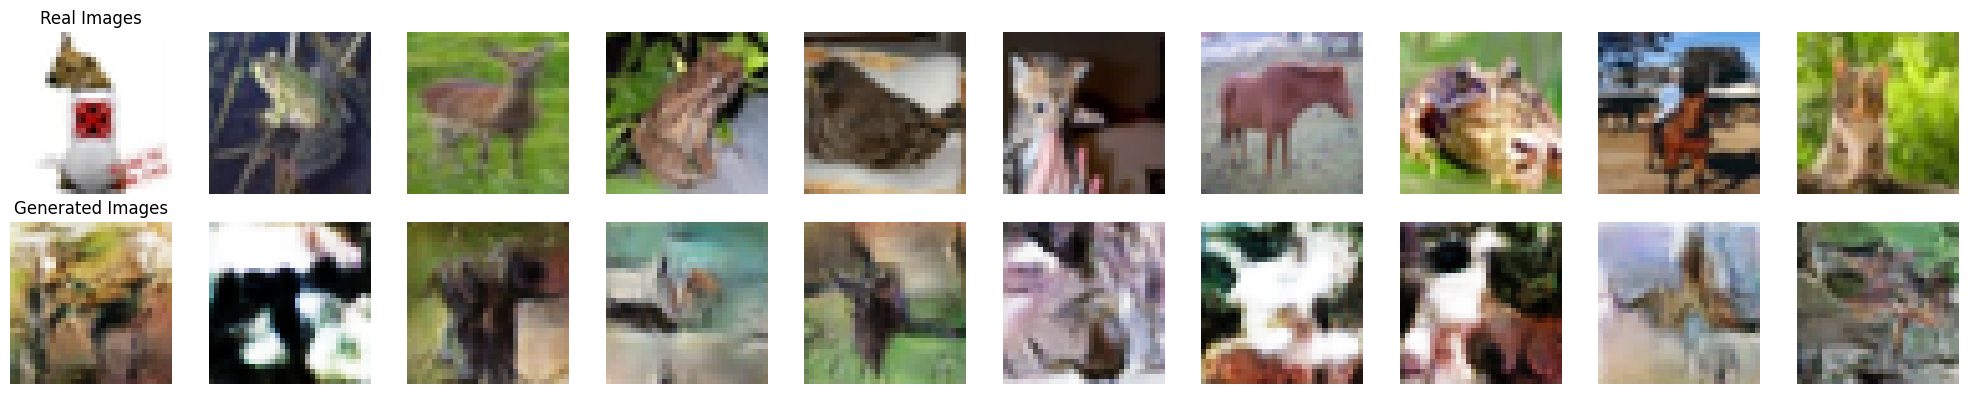

[Epoch 26/50] Loss D: -0.0271, Loss G: 0.0270 , FID score : 69.7756
[Epoch 27/50] Loss D: -0.0266, Loss G: 0.0269 , FID score : 68.5889
[Epoch 28/50] Loss D: -0.0261, Loss G: 0.0266 , FID score : 68.8944
[Epoch 29/50] Loss D: -0.0255, Loss G: 0.0263 , FID score : 67.5559
[Epoch 30/50] Loss D: -0.0251, Loss G: 0.0264 , FID score : 65.5535
[Epoch 31/50] Loss D: -0.0247, Loss G: 0.0261 , FID score : 63.8949
[Epoch 32/50] Loss D: -0.0243, Loss G: 0.0252 , FID score : 67.0224
[Epoch 33/50] Loss D: -0.0240, Loss G: 0.0261 , FID score : 65.5530
[Epoch 34/50] Loss D: -0.0236, Loss G: 0.0262 , FID score : 64.9530
[Epoch 35/50] Loss D: -0.0232, Loss G: 0.0256 , FID score : 63.5480
[Epoch 36/50] Loss D: -0.0230, Loss G: 0.0249 , FID score : 66.5882
[Epoch 37/50] Loss D: -0.0228, Loss G: 0.0250 , FID score : 64.6872
[Epoch 38/50] Loss D: -0.0225, Loss G: 0.0251 , FID score : 64.4417
[Epoch 39/50] Loss D: -0.0221, Loss G: 0.0256 , FID score : 63.8779
[Epoch 40/50] Loss D: -0.0217, Loss G: 0.0251 , 

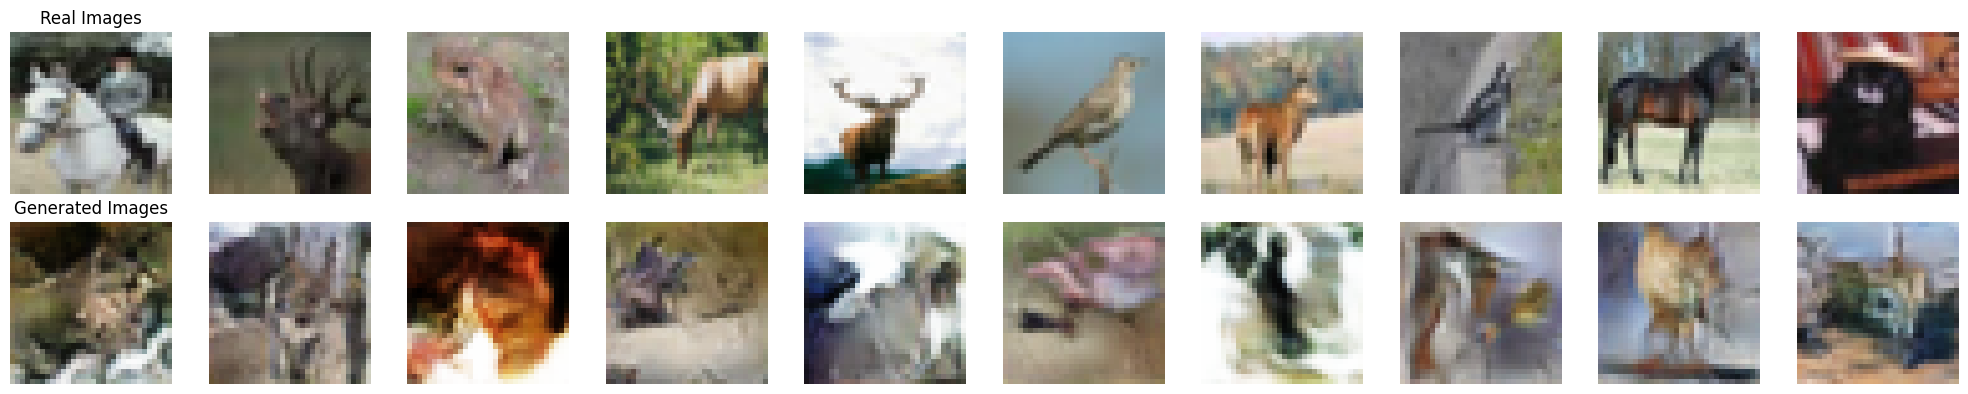

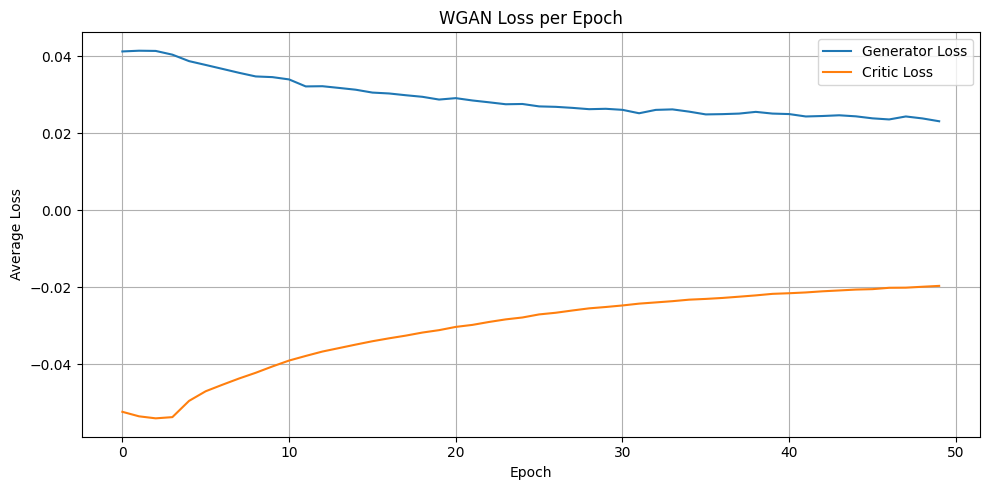

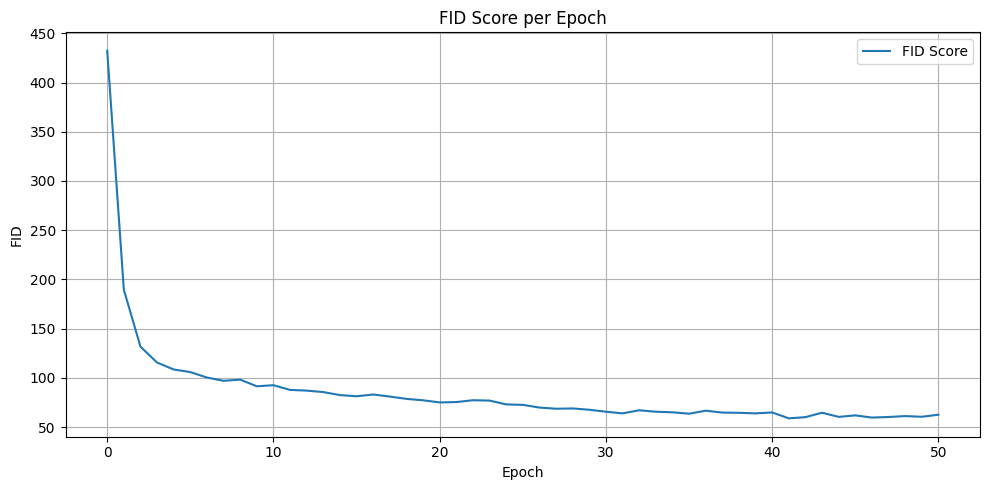

In [28]:
generator_10 = Generator_3(latent_dim).to(device)
critic_10 = Critic_7().to(device)
optimizer_g10 = optim.RMSprop(generator_10.parameters(), lr=lr)
optimizer_c10 = optim.RMSprop(critic_10.parameters(), lr=lr)

with torch.no_grad():
    noise = torch.randn(10, latent_dim).to(device)
    gen_imgs = generator_10(noise)

# Get real images for comparison
for imgs, _ in dataloader:
    real_imgs = imgs.to(device)
    break
    
print("Before Training...")
val = evaluate_fid(generator_10, dataloader, 5000 , 100 , latent_dim, device)
show_imgs(real_imgs, gen_imgs, n=10)
print(f" FID : {val}")
print("Training started...")

# Start training
fid_10 = train_WGAN(generator_10, critic_10, optimizer_g10, optimizer_c10, dataloader, device, latent_dim, n_critic , c , n_epochs , val)

**OSERVATION_10**

1. A moderate version of the strong Critic is applied with Generator 3 and same benchmark has been succesfully achived 
2. Makes the training more steady and stable 
3. Initially low losses can be noticed Though they are non saturating in nature , which shows Generator can be improved with more no of epochs 
4. Regularization Improves the behaviour

In [4]:
import pickle
fid_1 = pickle.load(open('fid_1.pkl', 'rb'))
fid_2 = pickle.load(open('fid_2.pkl', 'rb'))
fid_3 = pickle.load(open('fid_3.pkl', 'rb'))
fid_4 = pickle.load(open('fid_4.pkl', 'rb'))
fid_5 = pickle.load(open('fid_5.pkl', 'rb'))

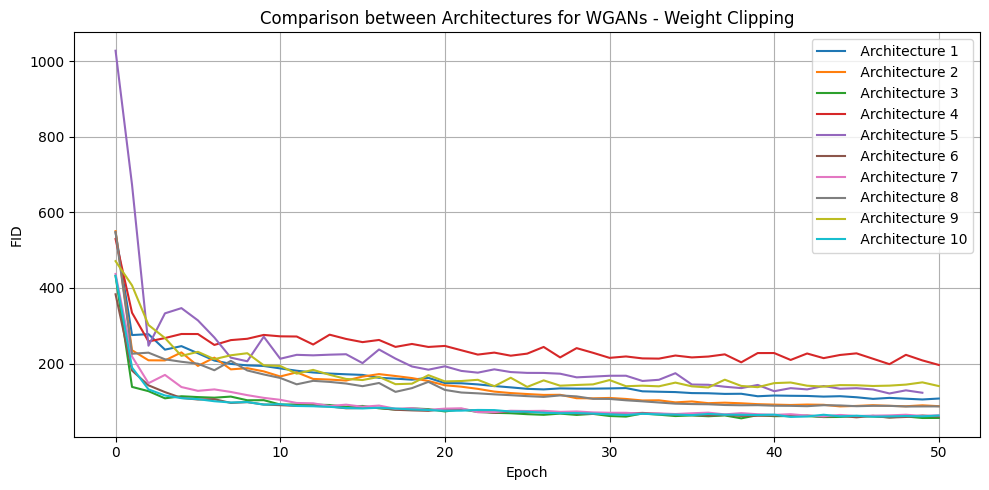

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(fid_1 ,label=' Architecture 1')
plt.plot(fid_2 ,label=' Architecture 2')
plt.plot(fid_3 ,label=' Architecture 3')
plt.plot(fid_4 ,label=' Architecture 4')
plt.plot(fid_5 ,label=' Architecture 5')
plt.plot(fid_6 ,label=' Architecture 6')
plt.plot(fid_7 ,label=' Architecture 7')
plt.plot(fid_8 ,label=' Architecture 8')
plt.plot(fid_9 ,label=' Architecture 9')
plt.plot(fid_10 ,label=' Architecture 10')
plt.xlabel("Epoch")
plt.ylabel("FID")
plt.title("Comparison between Architectures for WGANs - Weight Clipping")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
fid_3_last15 = fid_3[35:]
fid_7_last15 = fid_7[35:]
fid_6_last15 = fid_6[35:]
fid_10_last15 = fid_10[35:]

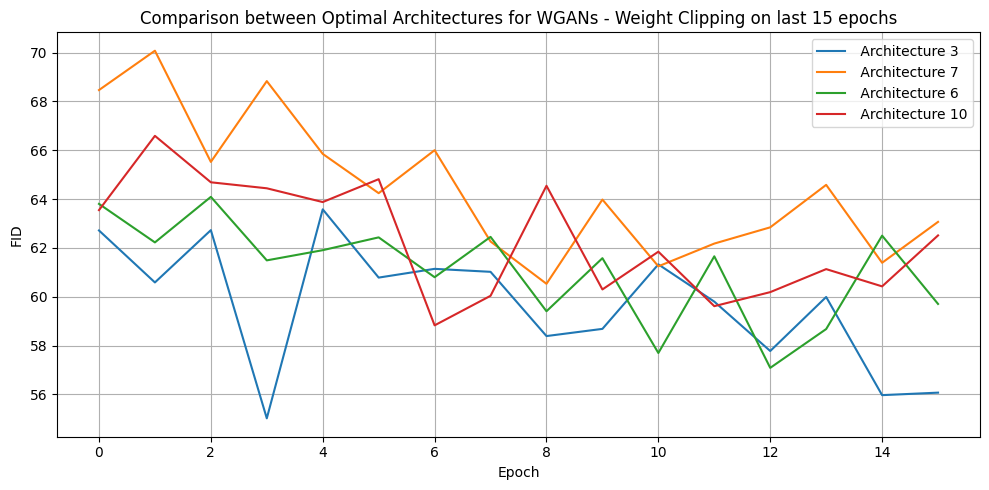

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(fid_3_last15 ,label=' Architecture 3')
plt.plot(fid_7_last15 ,label=' Architecture 7')
plt.plot(fid_6_last15 ,label=' Architecture 6')
plt.plot(fid_10_last15 ,label=' Architecture 10')
plt.xlabel("Epoch")
plt.ylabel("FID")
plt.title("Comparison between Optimal Architectures for WGANs - Weight Clipping on last 15 epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import pickle
pickle.dump(fid_10, open('fid_old.pkl', 'wb'))      # list is stored for further comparison while testing hyperparameters


***REMARK***

1. Architecture 9 fails   
2. Architecture 3 and 8 are doing well but not converging to the best  
3. Architecture 7 converges well but critic is found to be weaker in nature and lacks layernorm so not upgradable to WGAN-GP 
4. Architecture 2 performs pretty well but Maxpool layer is non-conventional an can be ignored 
5. Architecture 6 and 10 ar till now more optimal instaed of training curve and FID graph though Architecture 10 is our the best choice due to its light weight critic

***INFORMATION***

MORE NO OF INTERCHANGING CAN BE POSSIBLE HERE BUT FOR TIME CONSTRAINT WE ARE STOPPING HERE , IF TIME PERMITS WE WILL EXPLORE MORE 